# Anomalies Detection using Heuristic Method

## Loading Data

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

In [33]:
data_path = "../data/raw/waterDataTraining.csv"
df = pd.read_csv(data_path)
df.head(5)

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03T09:49:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2016-08-03T09:50:00Z,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,2016-08-03T09:51:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,2016-08-03T09:52:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,2016-08-03T09:53:00Z,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False


Like seen during the EDA we will drop the missing values from this dataset as we noticed for all of them when one value is missing it is actually the whole row that is empty.

In [34]:
df.dropna(inplace=True)

In [35]:
df.columns

Index(['Time', 'Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm',
       'Fm_2', 'EVENT'],
      dtype='object')

For now, we will only use the pH feature in order to predict the anomaly. 

In [36]:
columns_to_drop = ['Tp', 'Cl', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm','Fm_2']

In [37]:
data = df.drop(columns=columns_to_drop)
data.head(5)

,Time,pH,EVENT
0,2016-08-03T09:49:00Z,8.36,False
1,2016-08-03T09:50:00Z,8.36,False
2,2016-08-03T09:51:00Z,8.35,False
3,2016-08-03T09:52:00Z,8.35,False
4,2016-08-03T09:53:00Z,8.35,False


In [38]:
data['Time'] = pd.to_datetime(data['Time'])

In [39]:
data.set_index('Time', inplace=True)

In [40]:
data.head(5)

,pH,EVENT
Time,,
2016-08-03 09:49:00+00:00,8.36,False
2016-08-03 09:50:00+00:00,8.36,False
2016-08-03 09:51:00+00:00,8.35,False
2016-08-03 09:52:00+00:00,8.35,False
2016-08-03 09:53:00+00:00,8.35,False


## Base Model: Moving Average

In [41]:
window_size = 3
std_threshold = 2

data['Moving_Avg_pH'] = data['pH'].rolling(window=window_size).mean()
data['Moving_std_pH'] = data['pH'].rolling(window=window_size).std()

In [42]:
data.head(10)

,pH,EVENT,Moving_Avg_pH,Moving_std_pH
Time,,,,
2016-08-03 09:49:00+00:00,8.36,False,NaN,NaN
2016-08-03 09:50:00+00:00,8.36,False,NaN,NaN
2016-08-03 09:51:00+00:00,8.35,False,8.356667,0.005774
2016-08-03 09:52:00+00:00,8.35,False,8.353333,0.005774
2016-08-03 09:53:00+00:00,8.35,False,8.350000,0.000000
2016-08-03 09:54:00+00:00,8.35,False,8.350000,0.000000
2016-08-03 09:55:00+00:00,8.35,False,8.350000,0.000000
2016-08-03 09:56:00+00:00,8.35,False,8.350000,0.000000
2016-08-03 09:57:00+00:00,8.34,False,8.346667,0.005774


In [43]:
data['Anomaly'] = abs(data['pH'] - data['Moving_Avg_pH']) > (std_threshold * data['Moving_std_pH'])

In [44]:
data.head(5)

,pH,EVENT,Moving_Avg_pH,Moving_std_pH,Anomaly
Time,,,,,
2016-08-03 09:49:00+00:00,8.36,False,NaN,NaN,False
2016-08-03 09:50:00+00:00,8.36,False,NaN,NaN,False
2016-08-03 09:51:00+00:00,8.35,False,8.356667,0.005774,False
2016-08-03 09:52:00+00:00,8.35,False,8.353333,0.005774,False
2016-08-03 09:53:00+00:00,8.35,False,8.350000,0.000000,False


### Functions

Preprocessing:

In [46]:
def data_preprocessing(df, columns_to_drop):
    processed_df = df.copy()
    processed_df['Time'] = pd.to_datetime(processed_df['Time'])
    processed_df.set_index('Time', inplace=True)
    processed_df.drop(columns=columns_to_drop, inplace=True)

    return processed_df

Find best window:

In [45]:
def evaluate_window_size(df, window_size, std_threshold):
    data = df.copy()
    data['Moving_Avg_pH'] = data['pH'].rolling(window=window_size).mean()
    data['Moving_Std_pH'] = data['pH'].rolling(window=window_size).std()
    data['Anomaly'] = abs(data['pH'] - data['Moving_Avg_pH']) > (std_threshold * data['Moving_Std_pH'])
    
    precision = precision_score(data['EVENT'].dropna(), data['Anomaly'].dropna())
    recall = recall_score(data['EVENT'].dropna(), data['Anomaly'].dropna())
    f1 = f1_score(data['EVENT'].dropna(), data['Anomaly'].dropna())
    
    return data, precision, recall, f1

Plot for each windows the true anomalies vs detected ones:

In [60]:
def plot_anomalies(df, window):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['pH'], label='pH', color='blue')
    plt.scatter(df.index[df['EVENT']], df['pH'][df['EVENT']], color='green', label='True Anomaly', zorder=5)
    plt.scatter(df.index[df['Anomaly']], df['pH'][df['Anomaly']], facecolors='none', edgecolors='orange', label='Detected Anomaly', zorder=6)
    plt.legend()
    plt.title(f'Predicted Anomalies using Moving Average Heuristic Approach - Window Size: {window}')
    plt.xlabel('Time')
    plt.ylabel('pH')
    plt.show()

Test:

In [61]:
data_path = "../data/raw/waterDataTraining.csv"
df = pd.read_csv(data_path)
processed_df = data_preprocessing(df, columns_to_drop)

Window Size: 10, Precision: 0.015657620041753653
------------------------------------------------------------------------------------------------------------------------


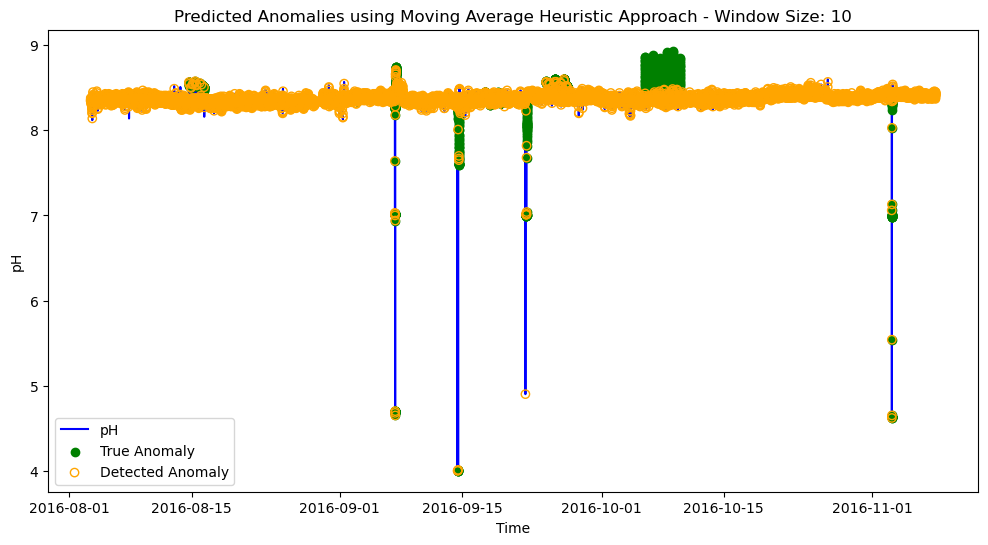

Window Size: 20, Precision: 0.0176349878158266
------------------------------------------------------------------------------------------------------------------------


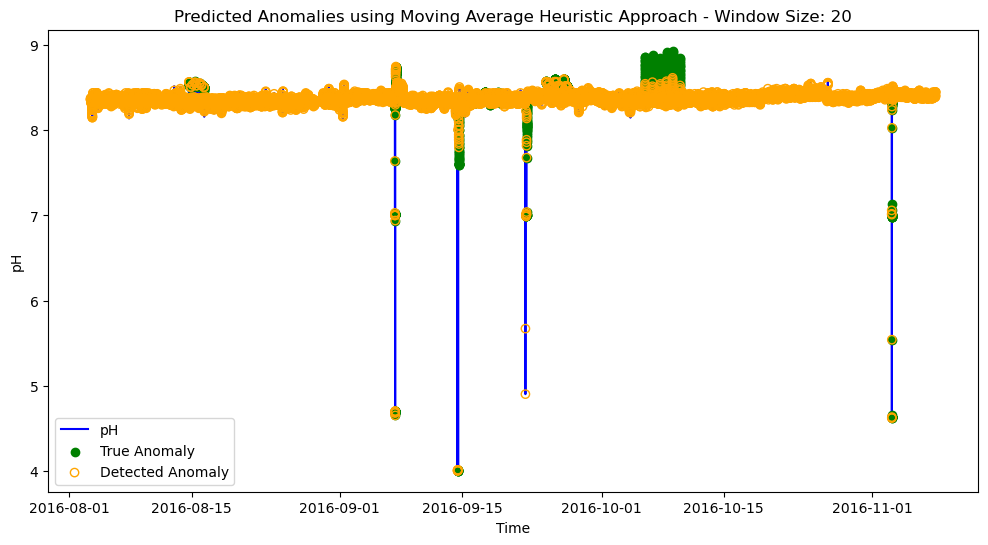

Window Size: 30, Precision: 0.01877032219923145
------------------------------------------------------------------------------------------------------------------------


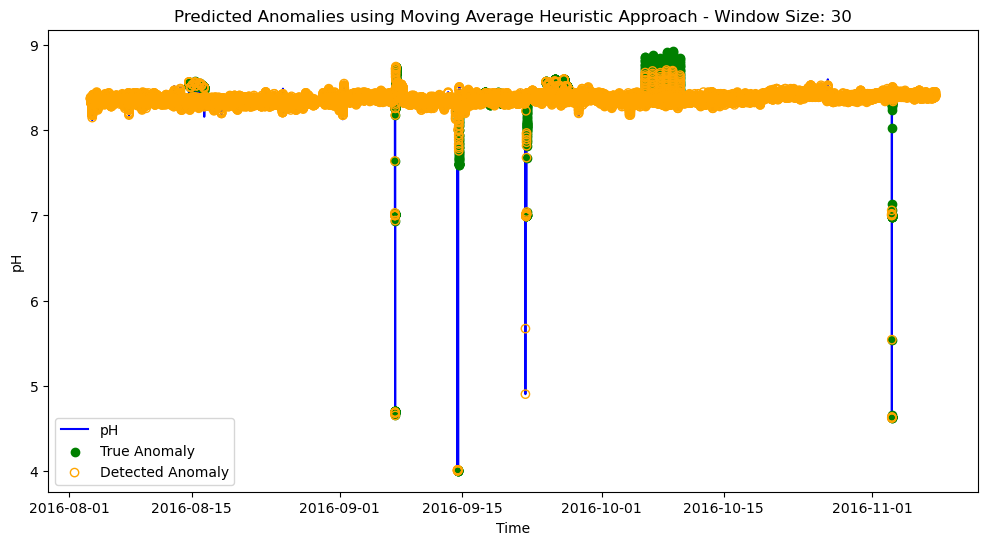

Window Size: 40, Precision: 0.022073578595317726
------------------------------------------------------------------------------------------------------------------------


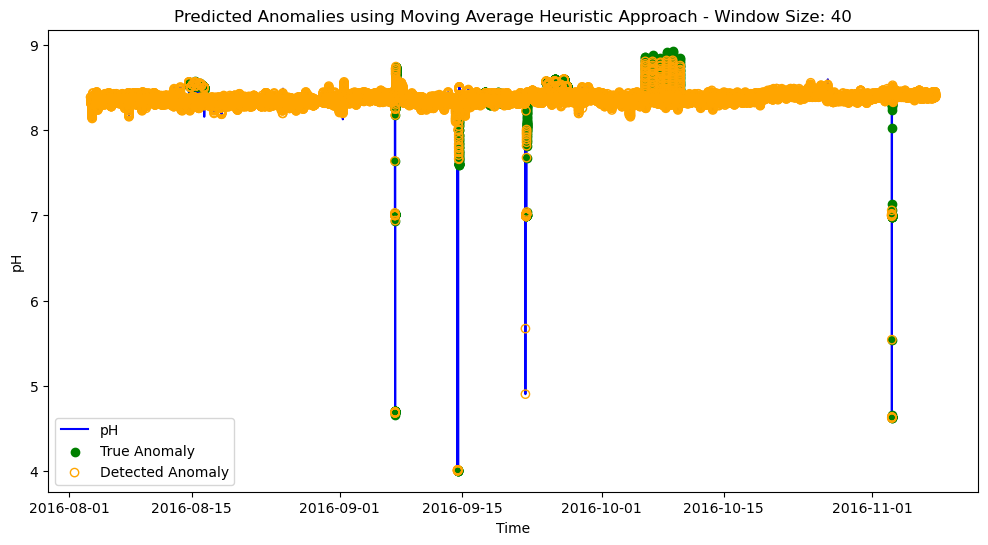

Window Size: 50, Precision: 0.026144664172456797
------------------------------------------------------------------------------------------------------------------------


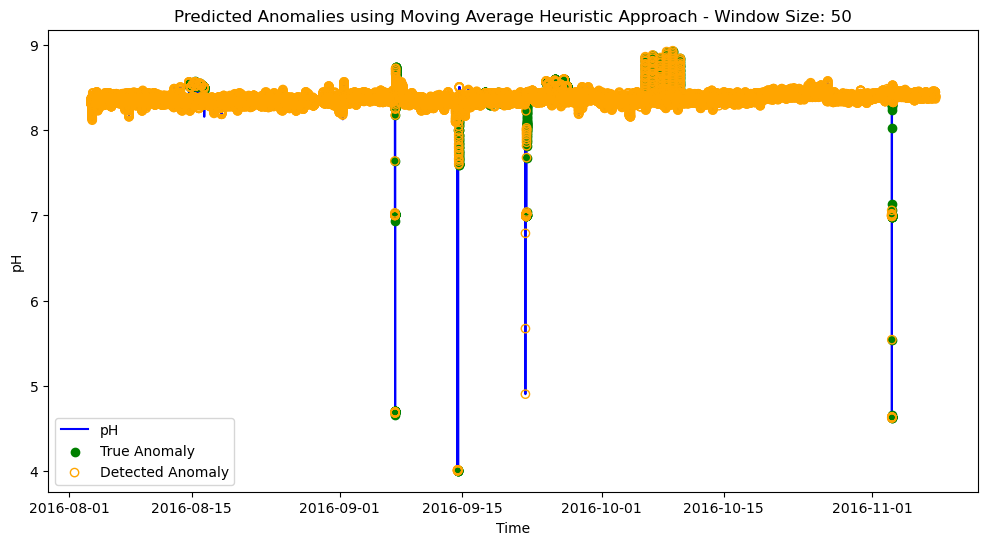

Window Size: 60, Precision: 0.029009304871373837
------------------------------------------------------------------------------------------------------------------------


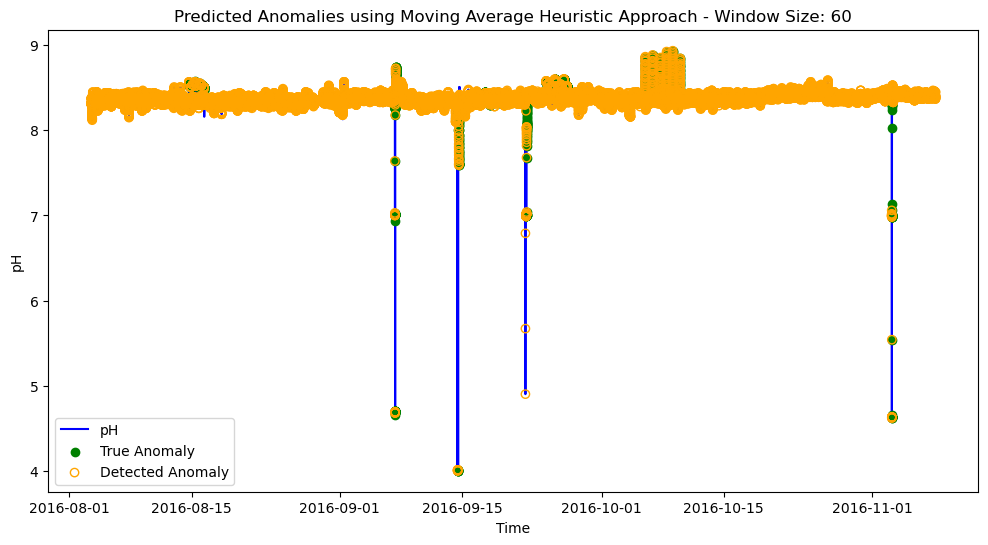

   Window_Size  Precision    Recall  F1_Score
0           10   0.015658  0.069525  0.025559
1           20   0.017635  0.159328  0.031755
2           30   0.018770  0.220742  0.034599
3           40   0.022074  0.286790  0.040992
4           50   0.026145  0.340093  0.048557
5           60   0.029009  0.368482  0.053784


In [65]:
results = []
window_sizes = [10, 20, 30, 40, 50, 60]
std_threshold = 2

for window in window_sizes:
    data, precision, recall, f1 = evaluate_window_size(processed_df, window, std_threshold)
    results.append((window, precision, recall, f1))
    print(f"Window Size: {window}, Precision: {precision}")
    print("----"*30)
    plot_anomalies(data, window)

results_df = pd.DataFrame(results, columns=['Window_Size', 'Precision', 'Recall', 'F1_Score'])
print(results_df)